In [350]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sb 

In [230]:
def convert_values(value):
    if value == 'NA':
        return 0
    else:
        return value

# Data load
## listings

In [231]:
listings_data_types = {'id':'int64', 'host_id':'int32', \
       'latitude':'float32', \
       'longitude':'float32', 'accommodates':np.ubyte,  \
       'availability_30':np.ubyte, 'availability_60':np.ubyte, 'availability_90':np.ubyte, 'availability_365':np.ushort,  'number_of_reviews':np.ushort, \
       'number_of_reviews_ltm':np.ushort, 'number_of_reviews_l30d':np.ubyte,  \
       'review_scores_rating':'float32', 'review_scores_accuracy':'float32', \
       'review_scores_cleanliness':'float32', 'review_scores_checkin':'float32', 'review_scores_communication':'float32', 'review_scores_location':'float32', \
       'review_scores_value':'float32', 'calculated_host_listings_count':np.ushort, \
       'calculated_host_listings_count_entire_homes':np.ushort, 'calculated_host_listings_count_private_rooms':np.ushort, \
        'calculated_host_listings_count_shared_rooms':np.ubyte, 'reviews_per_month':'float32'}

listings = pd.read_csv("http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/data/listings.csv.gz", \
                       low_memory=False, \
                       verbose=True, \
                       converters={'bedrooms': convert_values, 'beds': convert_values, 'maximum_nights':convert_values}, \
                       dtype = listings_data_types, \
                       parse_dates=['last_scraped', 'host_since','calendar_updated','calendar_last_scraped', 'first_review', 'last_review'])

Tokenization took: 2111.56 ms
Type conversion took: 1494.03 ms
Parser memory cleanup took: 12.19 ms


## calendar

In [232]:
calendar_data_types = {'listing_id': 'int64', \
    'minimum_nights': np.single, \
    'maximum_nights':'float32'}


calendar = pd.read_csv("http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/data/calendar.csv.gz", \
                       low_memory=False, \
                       verbose=True, \
                       converters={'adjusted_price': convert_values}, \
                       dtype = calendar_data_types, \
                       parse_dates=['date'])


Tokenization took: 11970.42 ms
Type conversion took: 9442.24 ms
Parser memory cleanup took: 279.64 ms


## reviews

In [233]:
reviews = pd.read_csv("http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/data/reviews.csv.gz", \
                      low_memory=False, \
                      verbose=True, \
                      converters={'adjusted_price': convert_values}, \
                      parse_dates=['date'])

Tokenization took: 5393.79 ms
Type conversion took: 3177.26 ms
Parser memory cleanup took: 24.08 ms


# memory optimization
- A regular read_csv for listings implies a memory usage of   50.32MB, but using dtype=listings_data_types   40.09MB:  18.7% reduction

- A regulat read_csv for calendar implies a memory usage of 1714.34MB, but using dtype=calendar_data_types 1469.43MB:  14.3% reduction

  A regulat read_csv for reviews  implies a memory usage of   72.37MB, but using dtype=reviews_data_types ther is not memory save.

I got this figures with 'sum(listings.memory_usage())/1024/1024'

# Ten questions

## 1.- For the compliance department ==> Which percentage of the listings have informed license?

In [234]:
total_listings = listings.shape[0]
grouped= listings.groupby(["license"],group_keys=False)
licenses = grouped.size()
print("Only {:5.4f}% of listings have reported license ".format(100* licenses.iloc[0]/total_listings))

Only 0.0011% of listings have reported license 


## 2.- For the compliance department ==> Which percentage of the listings have a verified host?

In [235]:
total_listings = listings.shape[0]
grouped= listings.groupby(["host_identity_verified"],group_keys=False)
verifications = grouped.size()
print("Only {:5.4f}% of listings have a verified host ".format(100* verifications.iloc[0]/total_listings))

Only 12.6771% of listings have a verified host 


## 3.- For operation department ==> At september time, which is the actual idle capacity for next 365 days?

In [237]:
total_daily_accomodates=listings["accommodates"].sum()
total_year_accomodates = total_daily_accomodates * 365
total_year_available = listings["availability_365"].sum()
idle_capacity = total_year_available / total_daily_accomodates
print("The idle capacity, measured as available accomodates versus total accomodates in 365 days, is {:5.4f}% ".format(idle_capacity))

The idle capacity, measured as available accomodates versus total accomodates in 365 days, is 38.2616% 


## 4.- For Revenue department ==> Which is the average price per accomodate and night in London?

In [311]:
df=listings[["price","availability_365", "accommodates", "minimum_nights", "number_of_reviews", "host_id"]]

In [313]:
df.loc[:,"price_num"] = df["price"].map(lambda x: x[1:])
df.loc[:,"price_num"] = df["price_num"].map(lambda x: x.replace(",",""))


In [315]:
df.loc[:,"price_num"]=df["price_num"].apply(pd.to_numeric)
df.loc[:,"price_accomodate"]=df["price_num"]/df["accommodates"]
average_price_accomodate_night =df["price_accomodate"].mean()
print("The Average price per accomodate and night in London is {:5.2f} pounds ".format(average_price_accomodate_night))

The Average price per accomodate and night in London is 64.02 pounds 


## 5.- For Revenue department ==> List host_id for listings with price set to zero.

In [343]:
da = df[["host_id","price_num"]]
mask = da["price_num"] == 0
result = da[mask]["host_id"].unique()
print("There are {} hosts with prices under 10 pounds per accomodate and night. This are their host ids ==> {} . CALL THEM TO CHECK ".format(len(result), list(result)))

There are 1 hosts with prices under 10 pounds per accomodate and night. This are their host ids ==> [3010498] . CALL THEM TO CHECK 



## 6.- For Revenue department ==> List host_id for listings with price per accomodate and night less than ten pounds

In [344]:
da = df[["host_id","price_num"]]
mask = (da["price_num"] > 0) & (da["price_num"] < 10)
result = da[mask]["host_id"].unique()
print("There are {} hosts with prices under 10 pounds per accomodate and night ==> ".format(len(result)), end="")
print(list(result))

There are 14 hosts with prices under 10 pounds per accomodate and night ==> [65184913, 2865823, 157459351, 175198291, 115638835, 122480489, 244699748, 258643139, 96692637, 3010498, 254289088, 296801818, 443134508, 86945986]


# to be continued. it is too late in Spain

In [348]:
da=df.drop(columns=["price", "price_num", "host_id"])

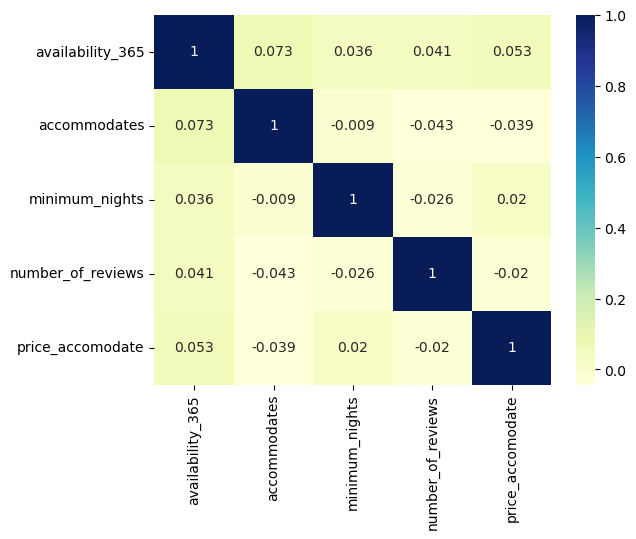

In [349]:
dataplot = sb.heatmap(da.corr(), cmap="YlGnBu", annot=True) 
  
# displaying heatmap 
mp.show() 

In [204]:
grouped= calendar.groupby(["listing_id", "available"],group_keys=False)
booked = grouped.size().unstack()
booked.fillna(0)
booked["booked"]= booked["f"]/365
booked

available,f,t,booked
listing_id,,,
13913,5.0,360.0,0.013699
15400,292.0,73.0,0.800000
17402,65.0,300.0,0.178082
24328,365.0,NaN,1.000000
25123,365.0,NaN,1.000000
...,...,...,...
973781286754517228,126.0,239.0,0.345205
973801695874775338,277.0,88.0,0.758904
973811685656289740,285.0,80.0,0.780822


In [224]:
df=listings[["id","availability_365", "accommodates"]]

In [228]:
df

,id,availability_365,accommodates
0,92644,217,2
1,93015,40,5
2,13913,360,1
3,15400,73,2
4,93734,196,2
...,...,...,...
87941,973781286754517228,239,3
87942,973801695874775338,88,2
87943,973811685656289740,80,7
87944,973882998775927897,364,10


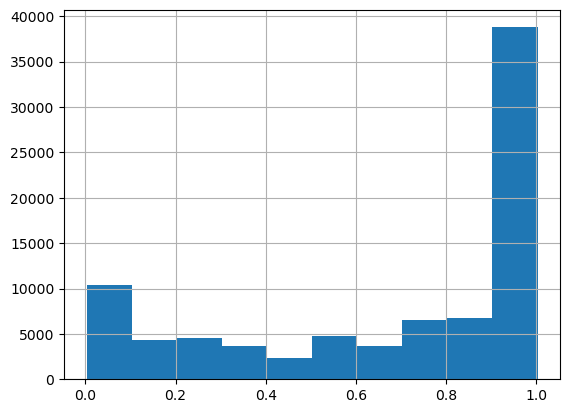

In [217]:
a=booked["booked"].hist(bins=10)